In [2]:
from __future__ import print_function

import torch
import torch.optim as optim

from torch.utils.data.dataset import Dataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.autograd import Variable
torch.backends.cudnn.bencmark = True
import torchvision
import torchvision.transforms as transforms

import os,sys,cv2,random,datetime,time,math
import argparse
import numpy as np

from net_s3fd import *
from s3fd import *
from bbox import *
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image


use_cuda = True

class CelebDataset(Dataset):
    """Dataset wrapping images and target labels
    Arguments:
        A CSV file path
        Path to image folder
        Extension of images
        PIL transforms
    """

    def __init__(self, csv_path, img_path, img_ext, transform=None):
        tmp_df = pd.read_csv(csv_path)
        assert tmp_df['Image_Name'].apply(lambda x: os.path.isfile(img_path + x + img_ext)).all(), \
            "Some images referenced in the CSV file were not found"

        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        self.X_train = tmp_df['Image_Name']
        self.y_train = self.mlb.fit_transform(tmp_df['Gender'].str.split()).astype(np.float32)

    def __getitem__(self, index):
        img = cv2.imread(self.img_path + self.X_train[index] + self.img_ext)
        img = cv2.resize(img, (256, 256))
        img = img - np.array([104, 117, 123])
        img = img.transpose(2, 0, 1)

        # img = img.reshape((1,)+img.shape)
        img = torch.from_numpy(img).float()
        # img = Variable(torch.from_numpy(img).float(),volatile=True)

        # if self.transform is not None:
        #    img = self.transform(img)

        label = torch.from_numpy(self.y_train[index])
        return img, label

    def __len__(self):
        return len(self.X_train.index)


train_data = "index.csv"
img_path = "data/Celeb_Small_Dataset/"
img_ext = ".jpg"
dset = CelebDataset(train_data,img_path,img_ext)
nw = 0
if use_cuda:
    nw = 1
train_loader = DataLoader(dset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=0 # 1 for CUDA
                         # pin_memory=True # CUDA only
                         )

def save(model, optimizer, loss, filename):
    save_dict = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.data[0]
        }
    torch.save(save_dict, filename)


def train_model(model, criterion, optimizer, num_classes, num_epochs=100):
    loss_hist = []
    min_loss = 1000
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()
        running_loss = 0.0

        for i, (img, label) in enumerate(train_loader):
            img = img.view((1,) + img.shape[1:])
            if use_cuda:
                data, target = Variable(img.cuda()), Variable(torch.Tensor(label).cuda())
            else:
                data, target = Variable(img), Variable(torch.Tensor(label))
            target = target.view(1, num_classes)

            optimizer.zero_grad()
            outputs = model(data)
            cur_loss = criterion(outputs, target)
            cur_loss.backward()
            running_loss += cur_loss.data[0].item()
            optimizer.step()
        
        running_loss /= 200
        if running_loss < min_loss:
            torch.save(model.state_dict(), 'gender_state_dict')
        loss_hist.append(running_loss)
        print(running_loss)
        #if running_loss < 1e-3:
        #    break
    return loss_hist

num_classes = 2
myModel = s3fd(num_classes)
loadedModel = torch.load('s3fd_convert.pth')
newModel = myModel.state_dict()
pretrained_dict = {k: v for k, v in loadedModel.items() if k in newModel}
new_params = [k for k in newModel if k not in loadedModel]
newModel.update(pretrained_dict)
myModel.load_state_dict(newModel)

criterion = nn.MSELoss()

#change gradient of the layer we choose
for pair in myModel.named_parameters():
    if pair[0] not in new_params:
        pair[1].requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, myModel.parameters()), lr=0.00002)
print('optimizer initialized')
if use_cuda:
    myModel = myModel.cuda()
    
loss_history = train_model(myModel, criterion, optimizer, num_classes, num_epochs=35)

optimizer initialized
Epoch 0/34
----------


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0.20259590165223926
Epoch 1/34
----------
0.1568976510805078
Epoch 2/34
----------
0.12205192831286694
Epoch 3/34
----------
0.10213046677003149
Epoch 4/34
----------
0.08134081669333681
Epoch 5/34
----------
0.0706117994575834
Epoch 6/34
----------
0.05923753051386484
Epoch 7/34
----------
0.04723920729906922
Epoch 8/34
----------
0.0409978127295949
Epoch 9/34
----------
0.03610179029782557
Epoch 10/34
----------
0.029808670117947713
Epoch 11/34
----------
0.02757582462480059
Epoch 12/34
----------
0.02264346513363307
Epoch 13/34
----------
0.019215096884418584
Epoch 14/34
----------
0.01790800368007041
Epoch 15/34
----------
0.01525316177992181
Epoch 16/34
----------
0.014030619045954325
Epoch 17/34
----------
0.011598070843375155
Epoch 18/34
----------
0.010897816985615982
Epoch 19/34
----------
0.009435205601089791
Epoch 20/34
----------
0.007952521914563703
Epoch 21/34
----------
0.007215616162420701
Epoch 22/34
----------
0.006435451363835476
Epoch 23/34
----------
0.005913183535

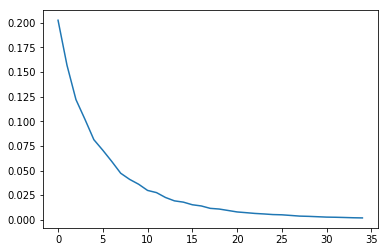

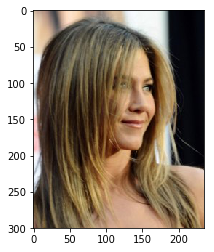

testImage1 -  Female


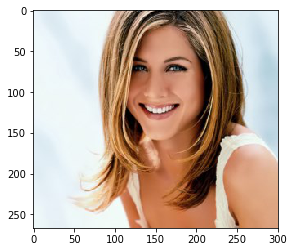

testImage2 -  Female


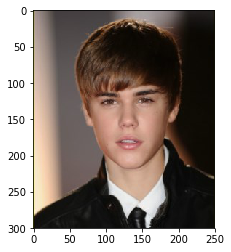

testImage3 -  Male


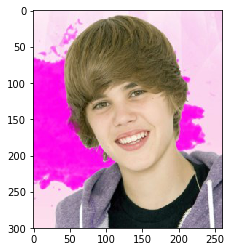

testImage4 -  Male


In [8]:
import matplotlib.pyplot as plt

def transform(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = img - np.array([104, 117, 123])
    img = img.transpose(2, 0, 1)

    img = img.reshape((1,) + img.shape)
    img = torch.from_numpy(img).float()

    return Variable(img.cuda())

def gender_class(out):
    if out[0][0].item() > 0.5:
        return 'Female'
    else:
        return 'Male'
    
plt.plot(loss_history)
plt.show()

img1 = cv2.imread('data/Test/TestCeleb_4/24-FaceId-0.jpg')
img1 = img1[:,:,::-1]
testImage1 = transform('data/Test/TestCeleb_4/24-FaceId-0.jpg')

img2 = cv2.imread('data/Test/TestCeleb_4/27-FaceId-0.jpg')
img2 = img2[:,:,::-1]
testImage2 = transform('data/Test/TestCeleb_4/27-FaceId-0.jpg')

img3 = cv2.imread('data/Test/TestCeleb_3/27-FaceId-0.jpg')
img3 = img3[:,:,::-1]
testImage3 = transform('data/Test/TestCeleb_3/28-FaceId-0.jpg')


img4 = cv2.imread('data/Test/TestCeleb_3/24-FaceId-0.jpg')
img4 = img4[:,:,::-1]
testImage4 = transform('data/Test/TestCeleb_3/32-FaceId-0.jpg')

output1 = myModel(testImage1)
output2 = myModel(testImage2)
output3 = myModel(testImage3)
output4 = myModel(testImage4)
plt.imshow(img1)
plt.show()
print("testImage1 - ", gender_class(output1))
plt.imshow(img2)
plt.show()
print("testImage2 - ", gender_class(output2))
plt.imshow(img3)
plt.show()
print("testImage3 - ", gender_class(output3))
plt.imshow(img4)
plt.show()
print("testImage4 - ", gender_class(output4))

The graph is ploted above

The learning rate used is 0.00002

The Diffculties I faced doing this project includes understanding the output of the structure and the use of tensor.
I started off with trying to implement and add gender convolution layers to all the detection layers, however, I discovered that for our dataset, many of the existing layers might only yield to unneccessary results. Additionally, the training time of the project is extensive with using all the layers, therefore, it took me some time trying to find the most suitable layer and make changes to code accordingly. 

Previous Attemps

In [ ]:
from __future__ import print_function

import torch
import torch.optim as optim

from torch.utils.data.dataset import Dataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.autograd import Variable
torch.backends.cudnn.bencmark = True
import torchvision
import torchvision.transforms as transforms

import os,sys,cv2,random,datetime,time,math
import argparse
import numpy as np

from net_s3fd import *
#from s3fd_gender import *
#import s3fd_gender
from s3fd import *
import s3fd
from bbox import *
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image




class CelebDataset(Dataset):
    """Dataset wrapping images and target labels
    Arguments:
        A CSV file path
        Path to image folder
        Extension of images
        PIL transforms
    """

    def __init__(self, csv_path, img_path, img_ext, transform=None):
    
        tmp_df = pd.read_csv(csv_path)
        assert tmp_df['Image_Name'].apply(lambda x: os.path.isfile(img_path + x + img_ext)).all(), \
"Some images referenced in the CSV file were not found"
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        self.X_train = tmp_df['Image_Name']
        #gender training
        self.y_train = self.mlb.fit_transform(tmp_df['Gender'].str.split()).astype(np.float32)
     
    #resizing the input image
    def __getitem__(self, index):
        img = cv2.imread(self.img_path + self.X_train[index] + self.img_ext)
        img = cv2.resize(img, (256,256))
        img = img - np.array([104,117,123])
        img = img.transpose(2, 0, 1)
        
        #img = img.reshape((1,)+img.shape)
        img = torch.from_numpy(img).float()
        #img = Variable(torch.from_numpy(img).float(),volatile=True)
        
        #if self.transform is not None:
        #    img = self.transform(img)
        
        #label === gender 
        label = torch.from_numpy(self.y_train[index])
        return img, label

    def __len__(self):
        return len(self.X_train.index)
    
    

transformations = transforms.Compose(
    [
     transforms.ToTensor()
     
     #transforms.Normalize(mean=[104,117,123])
     ])

train_data = "index.csv"
img_path = "data/Celeb_Small_Dataset/"
img_ext = ".jpg"
dset = CelebDataset(train_data,img_path,img_ext,transformations)
train_loader = DataLoader(dset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=1 # 1 for CUDA
                         # pin_memory=True # CUDA only
                         )

def save(model, optimizer, loss, filename):
    save_dict = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.data[0]
        }
    torch.save(save_dict, filename)
    

def train_model(model, criterion, optimizer, num_classes, num_epochs = 100):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train()
        running_loss = 0.0

        for i,(img,label) in enumerate(train_loader):
            img = img.view((1,)+img.shape[1:])
            genlist = []
            #loss = torch.tensor(1,2)
            #loss = []
                        
            #if use_cuda:
            #    data, target = Variable(img.cuda()), Variable(torch.Tensor(label).cuda())
            #else:
            data, target = Variable(img), Variable(torch.Tensor(label))
            target = target.view(num_classes,1)
            
            #output as desired form
            
            
            #apply soft max to gender layers

            optimizer.zero_grad()
            #run through model
            outputs = model(data)
            #print(outputs)
                
            #apply softmax to layers
            for j in range(len(outputs)//2): outputs[j*2] = F.softmax(outputs[j*2])
            #fetch data
            for j in range(len(outputs)//2): 
                ocls,ogen = outputs[i*2].data.cpu(),outputs[i*2+1].data.cpu()
                #print(ocls)
                
                FB,FC,FH,FW = ocls.size() # feature map size
                print(FH, FW)
                stride = 2**(i+2)    # 4,8,16,32,64,128
                anchor = stride*4
                for Findex in range(FH*FW):
                    windex,hindex = Findex%FW,Findex//FW
                    axc,ayc = stride/2+windex*stride,stride/2+hindex*stride
                    score = ocls[0,1,hindex,windex]
                    #loc = oreg[0,:,hindex,windex].contiguous().view(1,4)
                    if score<0.05: continue
                    gen = ogen[0,:,hindex,windex].contiguous().view(1,2)
                    print(gen)
                    #Append this gender prediction scores (1x2 dimension) to a list.
                    #genlist.append(gen)
                    #loss += criterion(gen,target)
                    genlist.append(gen)
                  
            #For each of the predictions in gender prediction list: 
            #calculate the loss and add it to the total loss for this iteration.
            
            for k,(gen) in enumerate(genlist):
                loss += criterion(gen, target)
                
            if i%50==0:
                print("Reached iteration ",i)
                running_loss += loss.data[0]
                #running_loss += loss
            
            #Update
            loss.backward()
            optimizer.step()
            
            #total running loss
            running_loss += loss.data[0]
            #running_loss += loss
            
        if epoch % 10 == 0:
            save(model, optimizer, loss, 'faceRecog.saved.model')
        print(running_loss)
        
        
#combine our model with the pre-trained model

num_classes = 2
myModel = (s3fd.s3fd_original(num_classes))
loadedModel = torch.load('s3fd_convert.pth')

newModel = myModel.state_dict()
pretrained_dict = {k: v for k, v in loadedModel.items() if k in newModel}

new_params = [k for k in newModel if k not in loadedModel]

newModel.update(pretrained_dict)
myModel.load_state_dict(newModel)

#if using GPU
use_cuda = True
myModel.eval()

In [ ]:
temp1 = myModel.conv4_3_norm_mbox_conf.weight[0][None,:,:,:]
temp2 = myModel.conv5_3_norm_mbox_conf.weight[0][None,:,:,:]
temp3 = myModel.fc7_mbox_conf.weight[0][None,:,:,:]
temp4 = myModel.conv6_2_mbox_conf.weight[0][None,:,:,:]

temp1 = torch.cat((temp1,temp1),0)
temp2 = torch.cat((temp2,temp2),0)
temp3 = torch.cat((temp3,temp3),0)
temp4 = torch.cat((temp4,temp4),0)
temp3.size()

In [ ]:
criterion = nn.MSELoss()
#criterion = nn.BCEloss()


# Turn the requires_grad off for all the parameters in your model.
# except the fc layers, ****************
#for param in myModel.parameters():
#    if param in myModel.fc7.parameters():
#        param.requires_grad = True 
#    else:
#        param.requires_grad = False

for pair in myModel.named_parameters():
    if pair[0] not in new_params:
        pair[1].requires_grad = False
        
        
# myModel.conv4_3_norm_mbox_conf.weight[0] += genTensor4_3
# Add this new tensor to the Gender layer's weight. 
# Make sure it has dimension N x C x H x W = N x 2 x H x W. (N is the number of images in the batch)


#Stochastic Gradient Descent.
#optimizer = optim.SGD(filter(lambda p: p.requires_grad,myModel.parameters()), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(filter(lambda p: p.requires_grad,myModel.parameters()), lr=0.0001, betas=(0.9, 0.999))

#if use_cuda: 
#    myModel = myModel.cuda()

# Call the training function defined above.    
model_ft = train_model(myModel, criterion, optimizer, num_classes, num_epochs=100)